### View model results and steady-state calibration

//anaconda/envs/py34/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


Levels:  [503 504 505 506 507 508 509 510 511 512 513 514 515 516 517]
Extent:  [0, 1500, 0, 1500]
*****Processing timestep: 
Head statistics
  min:  503.077
  max:  523.164
*****Processing timestep: 
Head statistics
  min:  503.076
  max:  521.054


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


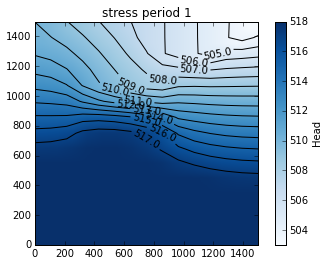

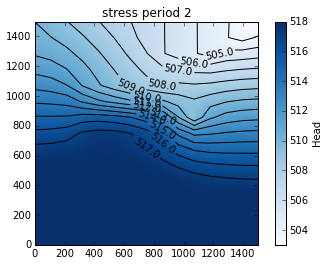

In [1]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import numpy as np
import pandas as pd

%matplotlib inline

#Create the binary output objects
path = 'modelfiles'
headobj = bf.HeadFile(os.path.join(path, 'P9Tcal.hds'))
cbobj = bf.CellBudgetFile(os.path.join(path, 'P9Tcal.cbc'))

times = headobj.get_times()

#Setup contour parameters
levels = np.arange(503, 518, 1)
extent = [0, 1500, 0, 1500]
print ('Levels: ', levels)
print ('Extent: ', extent)


# functions

def one2one(observed, simulated):
    '''
    make a one to one plot
    '''
    # initialize figure and axis
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # scatter plot of observed vs. simulated
    plt.scatter(observed, simulated)
    
    # plot one to one line
    lims = ax.get_ylim() + ax.get_xlim()
    mn, mx = np.min(lims), np.max(lims)
    
    plt.plot(np.arange(mn, mx+1), np.arange(mn, mx+1), color='k')
    ax.set_xlim(mn, mx)
    ax.set_ylim(mn, mx)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Simulated')
    
    # calculate statistics and plot
    residuals = simulated - observed
    me = np.mean(residuals)
    mea = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))

    ax.text(0.1, 0.9, 'Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse),
            va='top', ha='left', transform=ax.transAxes)

def plot_residuals(obs):
    '''
    spatial plot of residuals
    '''
    # oversimulated
    size_factor = 100
    over = obs[obs.residuals > 0]
    under = obs[obs.residuals < 0]
    
    # plot the heads
    plot_heads(heads, levels, extent)
    
    # plot the residuals on top
    plt.scatter(over.X, over.Y, s=np.abs(obs.residuals) * size_factor, c='b', zorder=100)
    plt.scatter(under.X, under.Y, s=np.abs(obs.residuals) * size_factor, c='r', zorder=100)
    

def plot_heads(heads, levels, extent, title=''):
    fig = plt.figure()
    plt.subplot(1, 1, 1, aspect='equal')
    plt.title(title)
    
    plt.imshow(heads, extent=extent, cmap='Blues', vmin=503, vmax=518)
    cb = plt.colorbar()
    cb.set_label('Head')
    cextent = [extent[0], extent[1], extent[3], extent[2]] # had problems with upper left vs. lower left origin
    CS = plt.contour(heads, levels=levels, extent=cextent, colors='k')
    plt.clabel(CS, inline=1, fontsize=10, fmt='%1.1f')


def plot_results(modelname):
    
    #bring in results
    headobj = bf.HeadFile('{}.hds'.format(modelname))
    head = headobj.get_data(totim=time)
    
    cbobj = bf.CellBudgetFile('{}.cbc'.format(modelname))
    riv_leakage = cbobj.get_data(totim=1, text='   RIVER LEAKAGE')
    rldf = pd.DataFrame(riv_leakage[0])
    rldf['state'] = ['gaining' if q < 0 else 'losing' for q in rldf.q]
    
    # get simulated values at observation locations
    obs['simulated'] = [head[0, obs.Row[i], obs.Column[i]] for i in range(len(obs))]
    one2one(obs.Head1, obs.simulated)
    
    obs['residuals'] = obs.simulated - obs.Head1
    plot_residuals(obs)
    
    # sum the leakage to the river, and the leakage out of the river
    r_out = rldf.loc[rldf.state == 'gaining', 'q'].sum()
    r_in = rldf.loc[rldf.state == 'losing', 'q'].sum()
    print ('Total River Leakage In: {}\nTotal River Leakage Out: {}'.format(r_in, r_out))
    

mytimes = [1.0, 4]
for iplot, time in enumerate(mytimes):
    print ('*****Processing timestep: '), time
    head = headobj.get_data(totim=time)
    
    #heads = np.flipud(head[0, :, :])
    heads = head[0, :, :]
    
    #Print statistics
    print('Head statistics')
    print ('  min: ', head.min())
    print ('  max: ', head.max())

    plot_heads(heads, levels, extent, title='stress period ' + str(iplot + 1))
plt.show()

#### Now extract the head results at the observation locations:

In [2]:
# bring in observation info
obs = pd.read_csv('observations.csv')
obs

,Well,Row,Column,Head1,Head2,Head3,Y,X
0,P,3,4,509.12,509.11,508.53,1250,350
1,G,5,8,508.19,507.99,506.84,1050,750
2,F,5,11,508.17,507.79,506.25,1050,1050
3,N,6,4,512.83,512.83,509.78,950,350
4,J,7,2,515.71,515.71,511.62,850,150
5,E,7,8,513.17,513.04,507.68,850,750
6,A,7,11,512.22,508.80,507.27,850,1050
7,B,7,14,511.95,511.29,507.63,850,1350
8,K,8,11,513.24,512.21,507.76,750,1050
9,Q,9,7,518.32,518.18,510.00,650,650


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


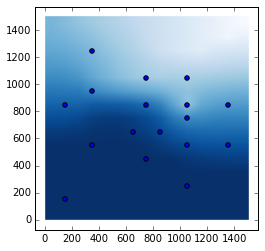

In [3]:
# show the observation locations with the head field
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(head[0,:,:], extent=extent, cmap='Blues', vmin=503, vmax=518)
ax.scatter(obs.X, obs.Y)


In [4]:
# get simulated values at observation locations
obs['simulated'] = [head[0, obs.Row[i], obs.Column[i]] for i in range(len(obs))]

# calculate mean error, mean absolute error, and RMS error

#### Calculate mean error,  mean absolute error and rms error
<img src="files/images/me.png">, <img src="files/images/ame.png">, <img src="files/images/rms.png">

In [5]:
obs['residuals'] = obs.simulated - obs.Head1
me = np.mean(obs.residuals)
mea = np.mean(np.abs(obs.residuals))
rmse = np.sqrt(np.mean(obs.residuals**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

Mean Error: 0.76
Mean Absolute Error: 0.99
RMS Error: 1.25


#### Make one to one plot of residuals

<imgsrc="images/me.png">

//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


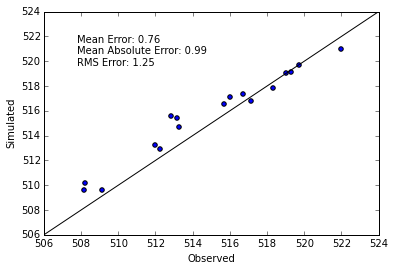

In [6]:
one2one(obs.Head1, obs.simulated)

#### Now make spatial plot of residuals

//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


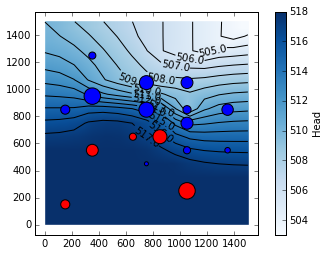

In [7]:
# oversimulated
size_factor = 100
over = obs[obs.residuals > 0]
under = obs[obs.residuals < 0]

# plot the heads
ax = plot_heads(heads, levels, extent)

# plot the residuals on top
plt.scatter(over.X, over.Y, s=np.abs(obs.residuals) * size_factor, c='b', zorder=100)
plt.scatter(under.X, under.Y, s=np.abs(obs.residuals) * size_factor, c='r', zorder=100)

#### Compare River leakance to observed values


In [8]:
cbobj.list_records()

(1, 1, b'   CONSTANT HEAD', 15, 15, -1, 2, 1.0, 1.0, 1.0)
(1, 1, b'FLOW RIGHT FACE ', 15, 15, -1, 1, 1.0, 1.0, 1.0)
(1, 1, b'FLOW FRONT FACE ', 15, 15, -1, 1, 1.0, 1.0, 1.0)
(1, 1, b'   RIVER LEAKAGE', 15, 15, -1, 5, 1.0, 1.0, 1.0)
(1, 2, b'         STORAGE', 15, 15, -1, 1, 0.0029325513169169426, 0.0029325513169169426, 1.0029325485229492)
(1, 2, b'   CONSTANT HEAD', 15, 15, -1, 2, 0.0029325513169169426, 0.0029325513169169426, 1.0029325485229492)
(1, 2, b'FLOW RIGHT FACE ', 15, 15, -1, 1, 0.0029325513169169426, 0.0029325513169169426, 1.0029325485229492)
(1, 2, b'FLOW FRONT FACE ', 15, 15, -1, 1, 0.0029325513169169426, 0.0029325513169169426, 1.0029325485229492)
(1, 2, b'   RIVER LEAKAGE', 15, 15, -1, 5, 0.0029325513169169426, 0.0029325513169169426, 1.0029325485229492)
(2, 2, b'         STORAGE', 15, 15, -1, 1, 0.005865102633833885, 0.008797653950750828, 1.0087976455688477)
(2, 2, b'   CONSTANT HEAD', 15, 15, -1, 2, 0.005865102633833885, 0.008797653950750828, 1.0087976455688477)
(2, 2, b'

In [9]:
# get the river leakage results from the output binary file for stress_period 1
# show the records
riv_output = cbobj.get_data(totim=1, text='   RIVER LEAKAGE')
riv_output

[rec.array([(1, 390.45489501953125), (2, -1265.17822265625), (3, -1507.1201171875),
  (4, -1485.3218994140625), (5, -1357.4053955078125),
  (6, -1162.009033203125), (7, -914.00830078125), (23, -2196.4296875),
  (39, -4455.60498046875), (40, -4197.6875), (41, -5016.04296875),
  (42, -8219.5947265625), (28, -3414.831298828125), (29, -6598.8359375),
  (15, -3748.529052734375)], 
           dtype=[('node', '<i4'), ('q', '<f4')])]

In [10]:
# make into a pandas DataFrame for readability
rldf = pd.DataFrame(riv_output[0])

# designate the state as gaining or losing
rldf['state'] = ['gaining' if q < 0 else 'losing' for q in rldf.q]
rldf

,node,q,state
0,1,390.454895,losing
1,2,-1265.178223,gaining
2,3,-1507.120117,gaining
3,4,-1485.321899,gaining
4,5,-1357.405396,gaining
5,6,-1162.009033,gaining
6,7,-914.008301,gaining
7,23,-2196.429688,gaining
8,39,-4455.604980,gaining
9,40,-4197.687500,gaining


In [11]:
# sum the leakage to the river, and the leakage out of the river
r_out = rldf.loc[rldf.state == 'gaining', 'q'].sum()
r_in = rldf.loc[rldf.state == 'losing', 'q'].sum()

print ('Total River Leakage In: {}\nTotal River Leakage Out: {}'.format(r_in, r_out))

Total River Leakage In: 390.45489501953125
Total River Leakage Out: -45538.59765625


The river leakage values should agree with those in the list file for stress period 1 (check that the files aren't mixed up!)

### Manual steady-state calibration
Manual calibration can be performed by adjusting inputs in ```p9_make_model.ipynb``` and then re-running the model  
higher heads are low, suggesting that K might be too high

simulated river exchange values are too high, also might indicate too high of K

#### Manual iteration 2
drop K for sand (Khvalues[1]) from 75 m/d to 10 m/d


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


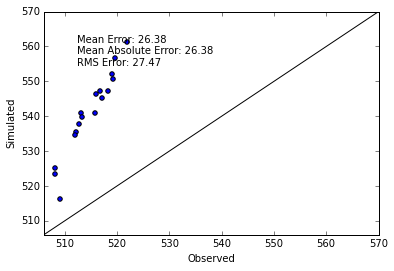

In [12]:
#bring in results
headobj = bf.HeadFile('modelfiles/P9_2.hds')
head = headobj.get_data(totim=time)

# get simulated values at observation locations
obs['simulated'] = [head[0, obs.Row[i], obs.Column[i]] for i in range(len(obs))]
one2one(obs.Head1, obs.simulated)

#### Manual iteration 3
sand = 60 m/d; silt = 1 m/d

Total River Leakage In: 1562.760009765625
Total River Leakage Out: -46787.1640625


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


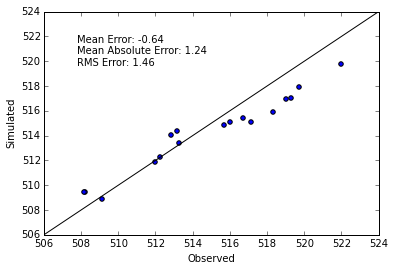

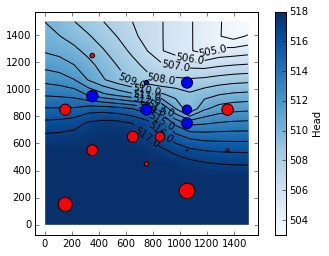

In [13]:
plot_results('modelfiles/P9_3')

In [14]:
os.getcwd()

'/Users/aleaf/Documents/GitHub/AppliedGWM_notebooks'

#### Manual iteration 4
sand = 45 m/d; silt = 15 m/d  
this value for 50% silt and clay is way to high in my opinion, unless there are connected sand and gravel seems through it, but it produces the best fit

Total River Leakage In: 772.4602661132812
Total River Leakage Out: -45996.85546875


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


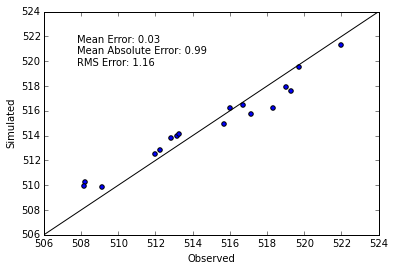

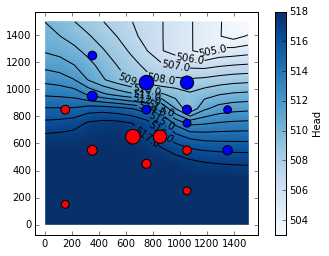

In [15]:
plot_results('modelfiles/P9_4')

#### Manual iteration 5
sand = 45 m/d; silt = 1 m/d

Total River Leakage In: 454.5055236816406
Total River Leakage Out: -45678.91015625


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


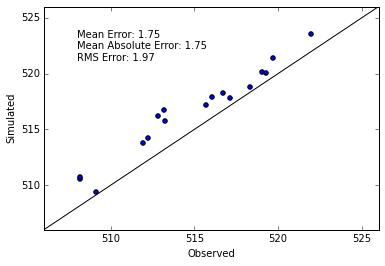

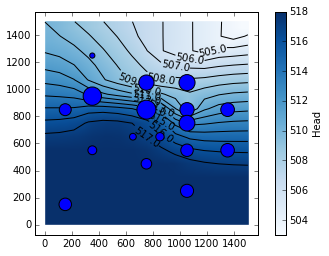

In [16]:
plot_results('modelfiles/P9_5')

### Zoned Calibration with PEST
 * 3 parameters: Ksand, Ksilt, and Rcond
 * created template files by pasting parameter names into existing upw and riv files  
     * see ```P9Tcal_upw.tpl``` and ```P9cal_riv.tpl```
 * created simple python script to extract head values and river conductance, and output these to text file  
     * see ```get_resultsT.py```
 * created a instruction file for PEST to read python script output  
     * see ```resultsT_txt.ins```
     
Pest is run by calling
```
>pest p9Tcal.pst
```
at the command line (must have PEST installed and in the system path) 

##### Overview of PEST run for this model  
* ```p9Tcal.pst``` is the PEST control file. It instructs PEST to create model input from the template files, and execute the batch file (see ```P9T.bat```, listed in the PEST control file under  **model command line**). 
* In this case we are also telling pest to run the python script ```get_resultsT.py``` to post-process the model results. 
* Lastly, the PEST control file tells PEST how to read the model outputs, using the instruction file (```resultsT_txt.ins```).

For more information about PEST, see the manual at: http://www.pesthomepage.org/Downloads.php


Observation weights:

    Head errors         stdev	error	weight 
    measurement_error	0.002	        500
    survey_error	     0.02		     50
    total	            0.022		    550
            
    River flux errors			
    toRiver	          0.1	 4555	 2.20E-04
    fromRiver	        0.1	 35	   2.86E-02
 
    
Starting objective function:  

    Starting phi for this iteration                          :  8.66844E+06
    Contribution to phi from observation group "heads"       :  6.91134E+06
    Contribution to phi from observation group "rflux"       :  1.75710E+06   
    
Optimal parameter values:  
    
     rcond     21410000.00000000         1.000000         0.000000    
     ksand     48.08820000000000         1.000000         0.000000    
     ksilt     6.391710000000000         1.000000         0.000000 

Total River Leakage In: 390.45489501953125
Total River Leakage Out: -45538.59765625


//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


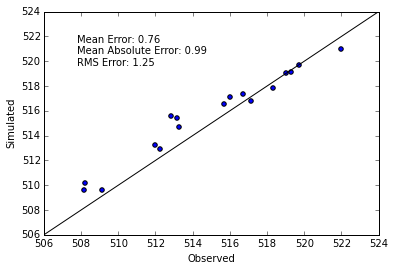

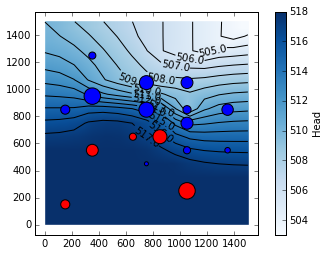

In [17]:
plot_results('modelfiles/P9Tcal')